In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Files
DATA_PATH = '../data'

os.listdir(DATA_PATH)

['.DS_Store',
 'internal_tagged_slip_lanes',
 'network-link-volumes_fall-2023_alameda',
 'Slip Lanes Communal Search Project.kmz']

In [132]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import text

user = "postgres"
password = os.getenv('POSTGRES_PW')
host = "127.0.0.1"
port = "5432"
database = "gradschool"

pg_url = URL.create(
    drivername='postgresql',
    username='postgres',
    host='127.0.0.1',
    database='gradschool',
    password=os.getenv('POSTGRES_PW')
)

pg_engine = create_engine(url)
# Test connection
try:
    with engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as ex:
    print(f'Sorry failed to connect: {ex}')

pg_connection = engine.connect()

Successfully connected to the PostgreSQL database


In [116]:
# Load Test File of CA bgs
shp_tl_CA_bgs_2020 = gpd.read_postgis(text('SELECT * FROM "mapping_basefiles"."tl_CA_bgs_2020";'), con = pg_connection)

## Files to Load

* **CA Block Groups**
- Basefile

* **Slip Lanes KML**
    - import from download
    - convert to shapefile
    - clean
    - buffer-ize

* **Replica trunk data**

* **Alameda County ___**

* **TIMS SafeTREC**
    - connect directly to SafeTREC server

In [7]:
# Load kml

# Load File
!pip install zipfile36
from zipfile import ZipFile
import fiona
os.listdir(DATA_PATH)

# Set File Paths
kmz_file_path = os.path.join(DATA_PATH, 'Slip Lanes Communal Search Project.kmz')
kmz_extraction_dir = os.path.join(DATA_PATH, 'internal_tagged_slip_lanes')
if not os.path.exists(kmz_extraction_dir):
    os.mkdir(kmz_extraction_dir)

# Extract into new directory
with ZipFile(kmz_file_path, "r") as kmz:
    kmz.extractall(kmz_extraction_dir)


33.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [8]:
# Check what's in there
print(os.listdir(kmz_extraction_dir))

# Necessary driver settings for fiona (party of GPD)
fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Look at the file
extracted_kml = os.path.join(kmz_extraction_dir,'doc.kml')
print(fiona.listlayers(extracted_kml))

# Go layer by layer
gdf_dict = {}
for layer in fiona.listlayers(extracted_kml):
    gdf = gpd.read_file(extracted_kml, driver='libkml', layer=layer)
    gdf_dict[layer] = gdf


#gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

['images', 'doc.kml']
['Berkeley Slip Lanes', 'Potential Slip Lanes', 'Oakland Potential Slip Lanes', 'Other Alameda County', 'Former Slip Lanes - From Chuck']


In [9]:
# Concatenate dictionary of dataframes together, but keep the layer name as a column
gdf_tagged_slip_lanes = pd.concat(gdf_dict, names=['Layer']).reset_index(level=0).reset_index(drop=True)
gdf_tagged_slip_lanes

,Layer,Name,Description,geometry
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),,POINT Z (-122.26849 37.85507 0.00000)
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),,POINT Z (-122.26954 37.85432 0.00000)
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,,POINT Z (-122.27875 37.88729 0.00000)
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),,POINT Z (-122.27873 37.88933 0.00000)
4,Berkeley Slip Lanes,?? Del Norte St -> Sutter St,,POINT Z (-122.27229 37.88909 0.00000)
...,...,...,...,...
309,Former Slip Lanes - From Chuck,## Allston -> Milvia,Removed when bike lane added betw 2020-2022,POINT Z (-122.27060 37.86894 0.00000)
310,Former Slip Lanes - From Chuck,## Allston Way -> Oxford St,,POINT Z (-122.26604 37.86960 0.00000)
311,Former Slip Lanes - From Chuck,## Hearst Ave -> Gayley Rd,,POINT Z (-122.25695 37.87541 0.00000)
312,Former Slip Lanes - From Chuck,## La Loma Ave -> Hearst Ave,,POINT Z (-122.25697 37.87560 0.00000)


In [118]:
# Clean Slip Lanes

# Goals:
# - split off prepend to categorize them
# - split name into start and end street

# Look for prepends
#gdf_tagged_slip_lanes['Active'] = np.where(gdf_tagged_slip_lanes['Name'].str.contains('^##', regex=True), False, True)
#gdf_tagged_slip_lanes['Is_SlipLane'] = np.where(gdf_tagged_slip_lanes['Name'].str.contains('^!!', regex=True), False, True)
#gdf_tagged_slip_lanes['Has_Questions'] = np.where(gdf_tagged_slip_lanes['Name'].str.contains('^\\?\\?', regex=True), True, False)


#gdf_tagged_slip_lanes.Name.str.split(' -> ', n=1, expand=True)
# Split on ->
#gdf_tagged_slip_lanes.Name.str.split(r'(?<=\D)(?=\d)', expand=True, n=1)

#pattern = r"(.*) -> (.*) \((.*)\)$"
pattern = r"^(.*) -> (.*?)(?: \((.*)\))?$"

#gdf_tagged_slip_lanes.Name.str.extract('(\w+\s+)')
gdf_tagged_slip_lanes[['o_road', 'd_road', 'card_loc']] = gdf_tagged_slip_lanes['Name'].str.replace(r'^(##|!!|\?\?) ', '', regex=True).str.extract(pattern)
gdf_tagged_slip_lanes['Name_clean'] = gdf_tagged_slip_lanes['Name'].str.replace(r'^(##|!!|\?\?) ', '', regex=True)

# Extract (DIR) into its own column
# Remove prepend

In [158]:
# write to 
# !pip install geoalchemy2
gdf_tagged_slip_lanes.to_postgis('alameda_tagged_slip_lanes_clean', con = pg_connection, schema='slip_lanes', if_exists = 'replace')

In [11]:
gdf_tagged_slip_lanes['Valid'] = (gdf_tagged_slip_lanes['Active'] & 
                                  gdf_tagged_slip_lanes['Is_SlipLane'] & 
                                  ~gdf_tagged_slip_lanes['Has_Questions'] & 
                                  gdf_tagged_slip_lanes['Layer'].isin(['Berkeley Slip Lanes', 'Oakland Potential Slip Lanes']))

gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']]

,Layer,Name,Description,geometry,Active,Is_SlipLane,Has_Questions,Valid
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),,POINT Z (-122.26849 37.85507 0.00000),True,True,False,True
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),,POINT Z (-122.26954 37.85432 0.00000),True,True,False,True
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,,POINT Z (-122.27875 37.88729 0.00000),True,True,False,True
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),,POINT Z (-122.27873 37.88933 0.00000),True,True,False,True
6,Berkeley Slip Lanes,Ashby Ave -> Claremont Ave,,POINT Z (-122.24509 37.85815 0.00000),True,True,False,True
...,...,...,...,...,...,...,...,...
129,Oakland Potential Slip Lanes,Ronada Ave -> Grand Ave,,POINT Z (-122.24443 37.82856 0.00000),True,True,False,True
131,Oakland Potential Slip Lanes,29th St -> Fairmount Ave,,POINT Z (-122.26048 37.81702 0.00000),True,True,False,True
132,Oakland Potential Slip Lanes,Broadway -> College Ave,Hairpin Turn,POINT Z (-122.25123 37.83673 0.00000),True,True,False,True
134,Oakland Potential Slip Lanes,Kennedy St -> 23rd Ave,,POINT Z (-122.23621 37.77357 0.00000),True,True,False,True


In [126]:
# Load replica
os.listdir(DATA_PATH)

gdf_network_link_volumes = gpd.read_file(os.path.join(DATA_PATH,'network-link-volumes_fall-2023_alameda'))
gdf_network_link_volumes.to_postgis('replica_netlinkvols_alameda_fall2023', con=pg_connection, schema = 'slip_lanes')


In [127]:
gdf_network_link_volumes

,linkId,trip_count,roadName,direction,startLat,startLon,endLat,endLon,highway,distance,...,tc_pub_tr,tc_on_dem,tc_prv,tc_prv_bv,tc_prv_nbv,tc_auto_p,tc_com,tc_com_med,tc_com_hvy,geometry
0,1648255130600919963,245615,"I 80, San Francisco ? Oakland Bay Bridge",East,37.813201,-122.361562,37.821831,-122.327715,motorway,1.941163,...,2873,19256,115934,9016,106918,101100,6452,5937,515,"LINESTRING (-122.36156 37.81320, -122.36094 37..."
1,1040820243380540071,245591,I 80,East,37.821978,-122.325567,37.822440,-122.321666,motorway,0.214994,...,2873,19256,115934,9016,106918,101100,6428,5933,495,"LINESTRING (-122.32557 37.82198, -122.32459 37..."
2,14244641574725013272,245568,I 80,East,37.821839,-122.327611,37.821978,-122.325567,motorway,0.111847,...,2873,19256,115934,9016,106918,101100,6405,5911,494,"LINESTRING (-122.32761 37.82184, -122.32622 37..."
3,5410421793402546439,245568,I 80,East,37.821831,-122.327715,37.821839,-122.327611,motorway,0.005592,...,2873,19256,115934,9016,106918,101100,6405,5911,494,"LINESTRING (-122.32771 37.82183, -122.32761 37..."
4,4460137061707001555,245504,I 80,East,37.823061,-122.318110,37.823092,-122.317942,motorway,0.009321,...,2873,19254,115934,9016,106918,101096,6347,5862,485,"LINESTRING (-122.31811 37.82306, -122.31794 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411214,7769060087848919114,1,NaN,West,37.803392,-122.262804,37.803425,-122.262892,service,0.005592,...,1,0,0,0,0,0,0,0,0,"LINESTRING (-122.26280 37.80339, -122.26289 37..."
411215,5370953850923904190,1,NaN,North,37.797105,-122.265126,37.797352,-122.264982,footway,0.018641,...,1,0,0,0,0,0,0,0,0,"LINESTRING (-122.26513 37.79711, -122.26498 37..."
411216,6871722207806666039,1,McDonell Trail,North,37.788104,-122.174199,37.791341,-122.174912,track,0.226800,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-122.17420 37.78810, -122.17414 37..."
411217,14530292867494552153,1,NaN,North,37.691535,-122.146322,37.692007,-122.146342,service,0.032311,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-122.14632 37.69154, -122.14634 37..."


In [24]:
# Pull from SWITRS
TIMS_QUERY = """select 
    CASE_ID,
    COUNTY,
    CITY,
    -- Time
    ACCIDENT_YEAR,
    COLLISION_DATE,
    COLLISION_TIME, -- <- data-time,
    DAY_OF_WEEK,
    -- Location
    PRIMARY_RD,
    SECONDARY_RD,
    DISTANCE,
    DIRECTION
    -- Conditions
    INTERSECTION,
    WEATHER_1,
    WEATHER_2,
    -- Factors
    PRIMARY_COLL_FACTOR,
    PCF_VIOL_CATEGORY,
    TYPE_OF_COLLISION,
    LIGHTING,
    PEDESTRIAN_ACCIDENT,
    BICYCLE_ACCIDENT,
    TRUCK_ACCIDENT,
    STWD_VEHTYPE_AT_FAULT,
    -- Injuries
    COLLISION_SEVERITY,
    NUMBER_KILLED,
    NUMBER_INJURED,
    PARTY_COUNT,
    -- Kills
    COUNT_PED_KILLED,
    COUNT_BICYCLIST_KILLED,
    -- GEOM
    POINT_X,
    POINT_Y
from 
    switrs
where 
    COUNTY = 'ALAMEDA' and CITY in ('OAKLAND', 'BERKELEY')
;
"""

# # mk db connection
tims_url = URL.create(
    drivername='mssql+pymssql',
    username='safetrec_app',
    host='sql-dnon01.ist.berkeley.edu',
    database='SAFETREC_TIMS',
    password=os.getenv('SAFETREC_PW')
)



In [30]:
import pymssql
tims_engine = create_engine(tims_url)

# engine = create_engine(tims_url)
with tims_engine.connect() as conn, conn.begin():
    df_TIMS = pd.read_sql_query(sql=text(TIMS_QUERY), con=conn)
    print('crash data collected')

crash data collected


In [46]:
# Convert df_TIMS -> gdf
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_TIMS.POINT_X, df_TIMS.POINT_Y)]
gdf_TIMS = GeoDataFrame(df_TIMS.drop(['POINT_X', 'POINT_Y'], axis=1), crs="EPSG:4326", geometry=geometry)

In [159]:
# !pip install --upgrade SQLAlchemy==1.4.46
#!pip install --upgrade GeoPandas
import sqlalchemy
#gdf_TIMS.to_postgis('TIMS_oakland_berkeley', con=pg_connection, schema = 'slip_lanes')
sum(gdf_TIMS.is_empty)/len(gdf_TIMS) # 3% are empty

gdf_TIMS.to_postgis('tims_oakberk', con=pg_connection, schema='slip_lanes', if_exists = 'replace') ### NO CAPITAL LETTERS


<AxesSubplot: >

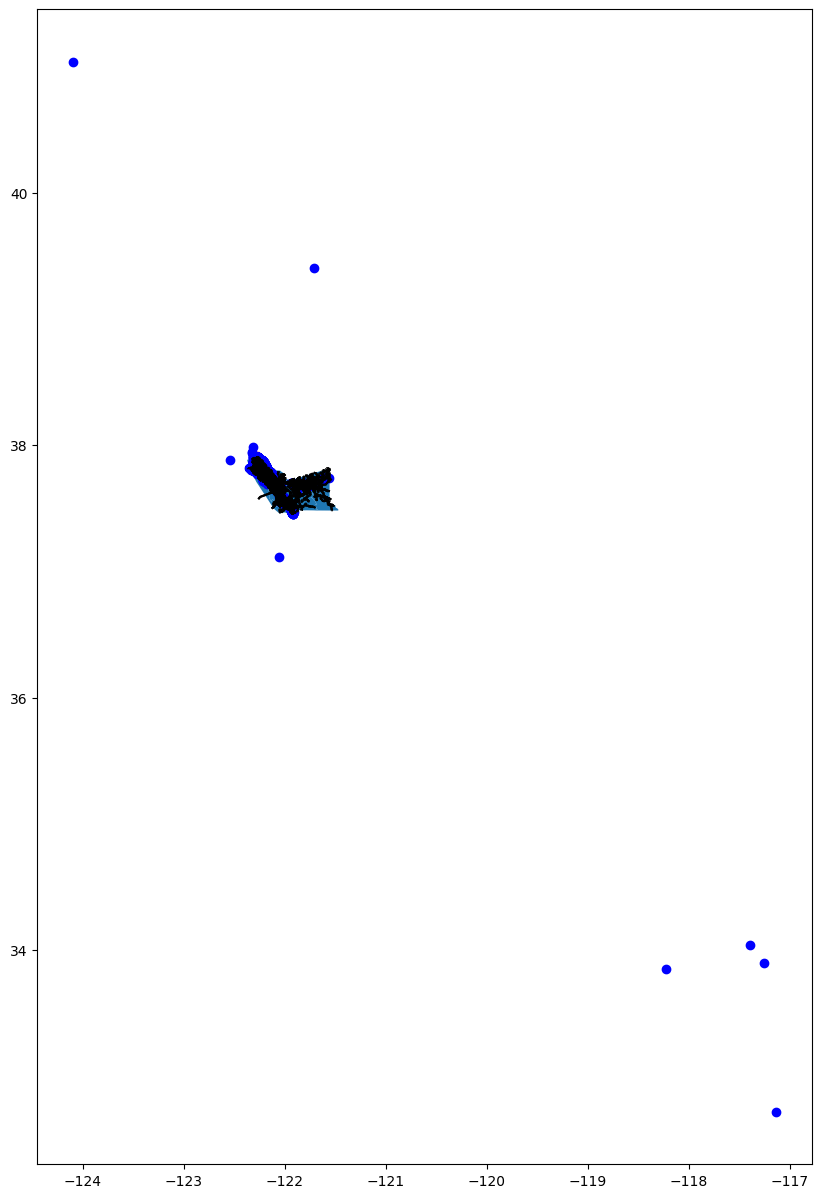

In [160]:
# Plot them to see how things are aligning so far
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].plot(ax=ax)
gdf_network_link_volumes.plot(ax=ax, color='black')
gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].plot(ax=ax, color = 'pink')
gdf_TIMS.plot(ax=ax, color = 'blue')

In [2]:
# Interactive version
#!pip install folium
#!pip install mapclassify
import folium

m = shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].explore()
gdf_network_link_volumes.explore(
    m=m,
    color = 'black'
)
gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].explore(
    m=m,
    color='red',
    marker_kwds=dict(radius=5, fill=True)
)

folium.TileLayer("CartoDB positron", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)
m



# fig, ax = plt.subplots(figsize=(20, 15))
# shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].plot(ax=ax)
# gdf_network_link_volumes.plot(ax=ax, color='black')
# gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].plot(ax=ax, color = 'pink')

NameError: name 'shp_tl_CA_bgs_2020' is not defined